[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arusl/tmdb-multimodal-inference/blob/main/tmdb_multimodal_inference.ipynb)

# Inference: Multimodal Movie Genre Classification

This notebook shows how to use an already pre-trained model to make predictions on new data. 

Input: **Movie Overview (text) & Movie Poster (image)**

Output: **Predicted movie genre**

Example:

<img src="https://imgur.com/3L3vdBa.jpeg" width="600"></img>

The model used in this notebook is trained following the architectures and codes specified in this [Github repo](https://github.com/dh1105/Multi-modal-movie-genre-prediction).

Some explanations regarding how to train and evaluate the models can be found in this [Medium article](https://towardsdatascience.com/multimodal-deep-learning-to-predict-movie-genres-e6855f814a8a) and the above Github repo.

Basically, the model receives inputs from two modalities, image (movie poster) and text (movie overview). Images are trained using CNN and texts are trained using LSTM. Below is the illustration from the above Medium article.

<img src="https://miro.medium.com/max/4800/1*b4MoSHYfA9U8nPFTXAb4xg.png" width="400"></img>

Illustration from [Source](https://towardsdatascience.com/multimodal-deep-learning-to-predict-movie-genres-e6855f814a8a)

### Change text-wrap format in Colab

The below code is optional. It is used display long texts in Google Colab with the 'wrapped' format.

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### Connect to Google Drive and Import necessary packages

This notebook needs to connect to Google Drive to access:
1. The trained model --> to predict new data
2. Training set --> to prepare the Tokenizer that will be used to tokenize new data
3. The poster images of the new data that we want to predict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The model was trained using CNN and LSTM with Keras, so this notebook will also use Keras to load the model, tokenize, and pad sequences.

NLTK is used to pre-process the movie overviews texts, such as removing punctuations and stopwords.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

import pandas as pd
import numpy as np
import pickle
import re
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from string import punctuation

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Load trained model and available genres

Let's load the model.

In [ ]:
model = load_model("/content/drive/MyDrive/Colab Notebooks/tmdb-multimodal/model-all/base_model_word2vec_lstm.h5")

The trained model will predict if a movie (based on its overview+poster) belong to each of the genre below. Let's prepare an array to hold these genres.

In [ ]:
genres = np.array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller',
       'War', 'Western'])

### Prepare the Movie Data to be Predicted

Let's prepare the movie data we want to predict. 

Firstly, let's create two lists containing the titles and movie overviews. The movie title will not be used for inference, but it will make it easier for us to understand the overview and poster later.

In [ ]:
#movie titles
titles = ["Attack on Titan",
          "Our Beloved Summer",
          "Shang-Chi",
          "Money Heist / La Casa de Papel"]

# movie overview/synopsis
raw_overviews = ["The plot of Attack on Titan centers on a civilization inside three walls, the last location where humans still live. Over one hundred years ago, humanity was driven to the brink of extinction after the emergence of humanoid giants called Titans, who attack and eat humans on sight. The last remnants of humanity retreated behind three concentric walls and enjoyed nearly a century of peace. To combat Titans, the country's military employs Vertical Maneuvering Equipment, a set of waist-mounted grappling hooks and gas-powered propulsion enabling immense mobility in three dimensions.",
             "A coming of age romantic comedy that revolves around Choi Ung (Choi Woo-shik) and Kook Yeon-Soo (Kim Da-mi), ex-lovers who broke up with a promise to never meet again. As luck would have it, the documentary they filmed ten years ago in high school went viral and they are forced to face the cameras together again by their producer friend who seems to have feelings for Kook Yeon-Soo. The series depicts their complicated feelings and growth.",
             "Thousands of years ago, Xu Wenwu finds the Ten Rings, ten mystical weapons that grant their user immortality and great power. Wenwu amasses an army of warriors called the Ten Rings and conquers many kingdoms and topples governments throughout history. In the present day, Shang-Chi works as a valet with his best friend Katy. While on the bus on their way to work, Shang-Chi and Katy are attacked by the Ten Rings led by Razor Fist. Shang-Chi fights them off, but discovers that his pendant given to him by his mother has been taken. Fearing that the Ten Rings will attack Xialing for her pendant, Shang-Chi decides to track her down and reveals his past to Katy, who agrees to help him. They find her at an underground fight club in Macau, which she owns; Xialing expresses her resentment toward Shang-Chi and their father. The fight club is then attacked by the Ten Rings, with Wenwu unexpectedly arriving to capture Shang-Chi, Katy, and Xialing. Wenwu and the Ten Rings arrive to destroy the seal and a battle ensues. Wenwu and Shang-Chi fight, which ends with Wenwu casting Shang-Chi into the nearby lake. Guided by Li's voice, Wenwu begins breaking down the seal with the rings, which unbeknownst to him causes many of the Dweller-in-Darkness' minions to escape. The villagers and the Ten Rings call a truce in order to stop the minions. Shang-Chi is revived by the Great Protector before rising out of the water to battle the minions. Wenwu and Shang-Chi fight once more, with Shang-Chi emerging victorious. Strengthened by the souls taken by the minions, the Dweller-in-Darkness escapes. Recognizing that his wife is dead, a humbled Wenwu sacrifices himself to save Shang-Chi and gives him the ten rings. The Dweller-in-Darkness is eventually killed by the combined efforts of Shang-Chi, the Great Protector, Xialing, and Katy.",
             "Set in Madrid, a mysterious man known as the 'Professor' recruits a group of eight people, who choose city names as their aliases, to carry out an ambitious plan that involves entering the Royal Mint of Spain, and escaping with €984 million. After taking 67 people hostage inside the Mint, the team plans to remain inside for 11 days to print the money as they deal with elite police forces. In the events following the initial heist, the group's members are forced out of hiding and prepare for a second heist, this time on the Bank of Spain, as they again deal with hostages and police forces."]

raw_overviews

["The plot of Attack on Titan centers on a civilization inside three walls, the last location where humans still live. Over one hundred years ago, humanity was driven to the brink of extinction after the emergence of humanoid giants called Titans, who attack and eat humans on sight. The last remnants of humanity retreated behind three concentric walls and enjoyed nearly a century of peace. To combat Titans, the country's military employs Vertical Maneuvering Equipment, a set of waist-mounted grappling hooks and gas-powered propulsion enabling immense mobility in three dimensions.",
 'A coming of age romantic comedy that revolves around Choi Ung (Choi Woo-shik) and Kook Yeon-Soo (Kim Da-mi), ex-lovers who broke up with a promise to never meet again. As luck would have it, the documentary they filmed ten years ago in high school went viral and they are forced to face the cameras together again by their producer friend who seems to have feelings for Kook Yeon-Soo. The series depicts their

Secondly, let's prepare a list containing the corresponding poster images of the movies mentioned before.

In [ ]:
paths = [str("/content/drive/MyDrive/Colab Notebooks/tmdb-multimodal/new_posters/aot.jpeg"),
         str("/content/drive/MyDrive/Colab Notebooks/tmdb-multimodal/new_posters/our_beloved_summer.jpg"),
         str("/content/drive/MyDrive/Colab Notebooks/tmdb-multimodal/new_posters/shangchi.jpeg"),
         str("/content/drive/MyDrive/Colab Notebooks/tmdb-multimodal/new_posters/money_heist.jpg")]

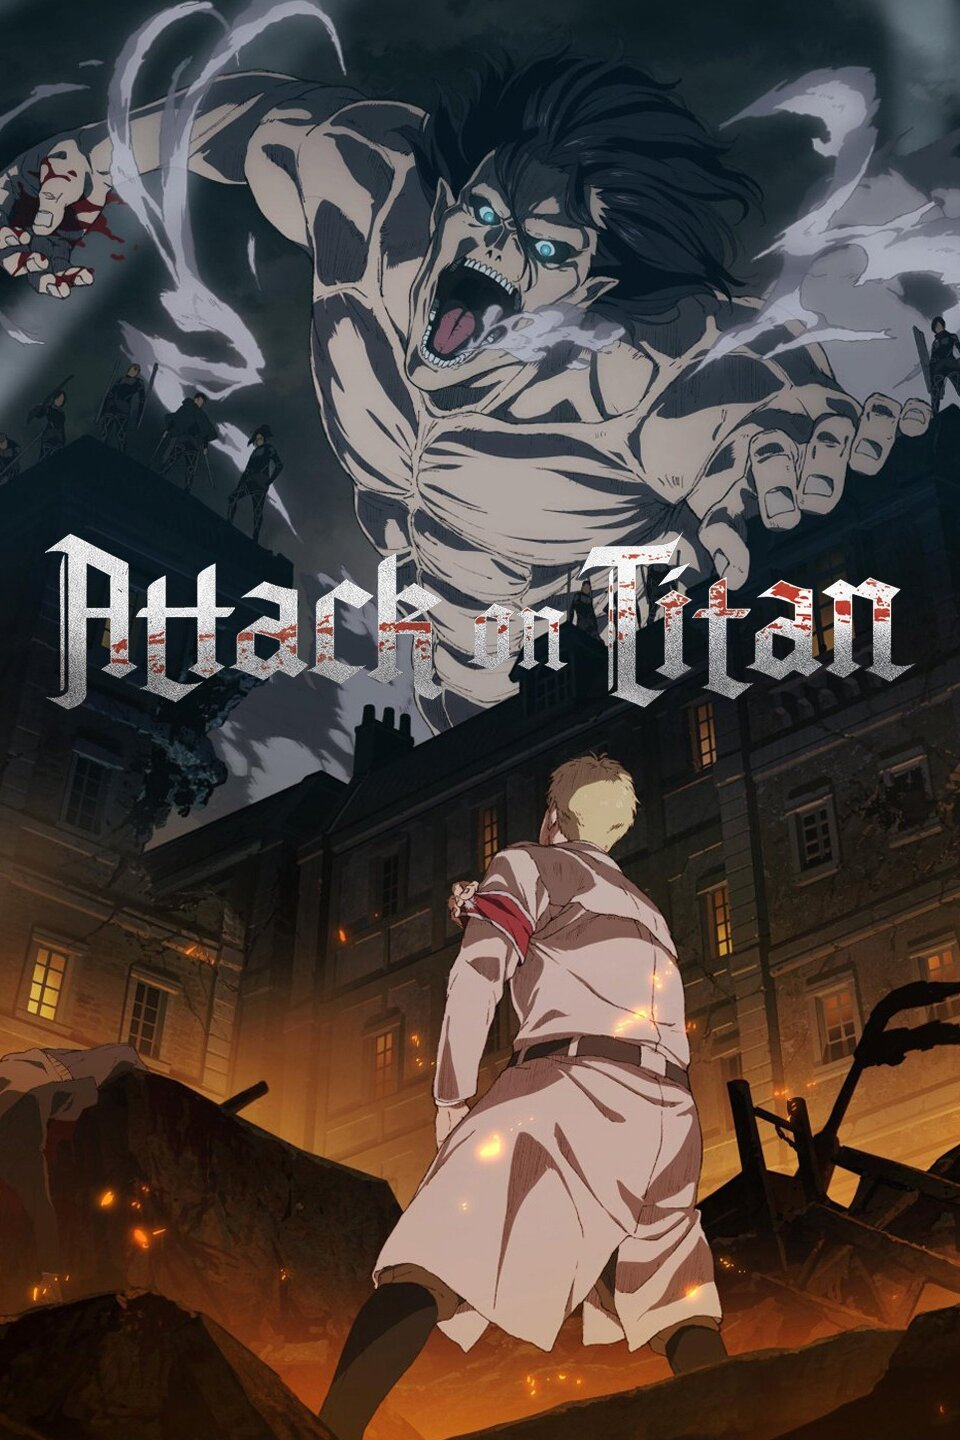

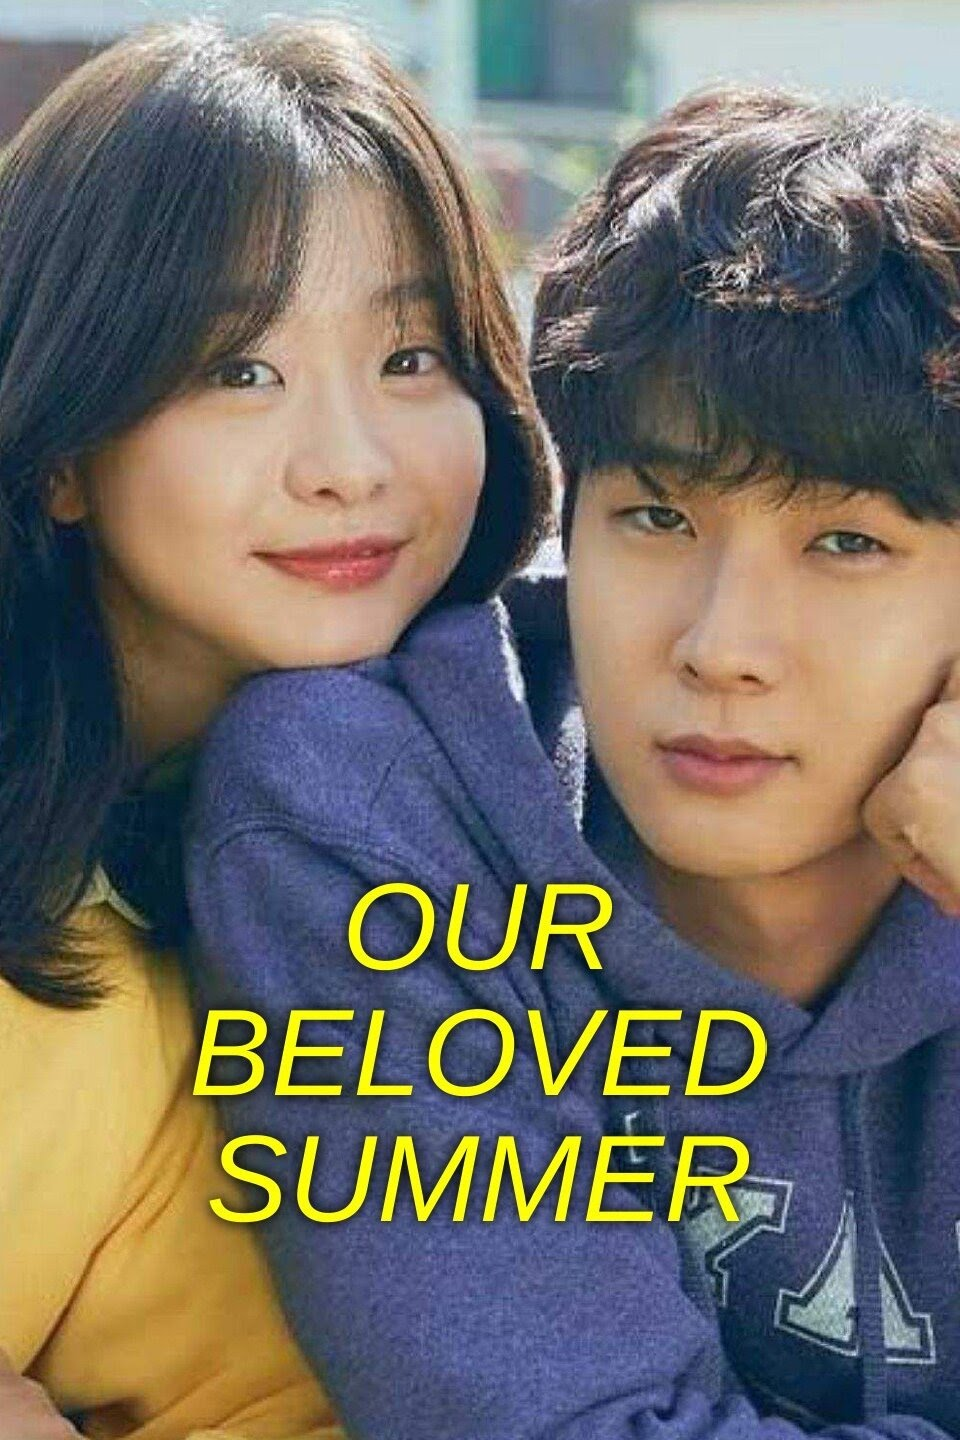

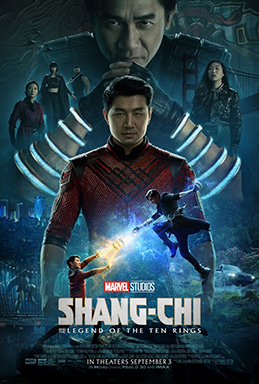

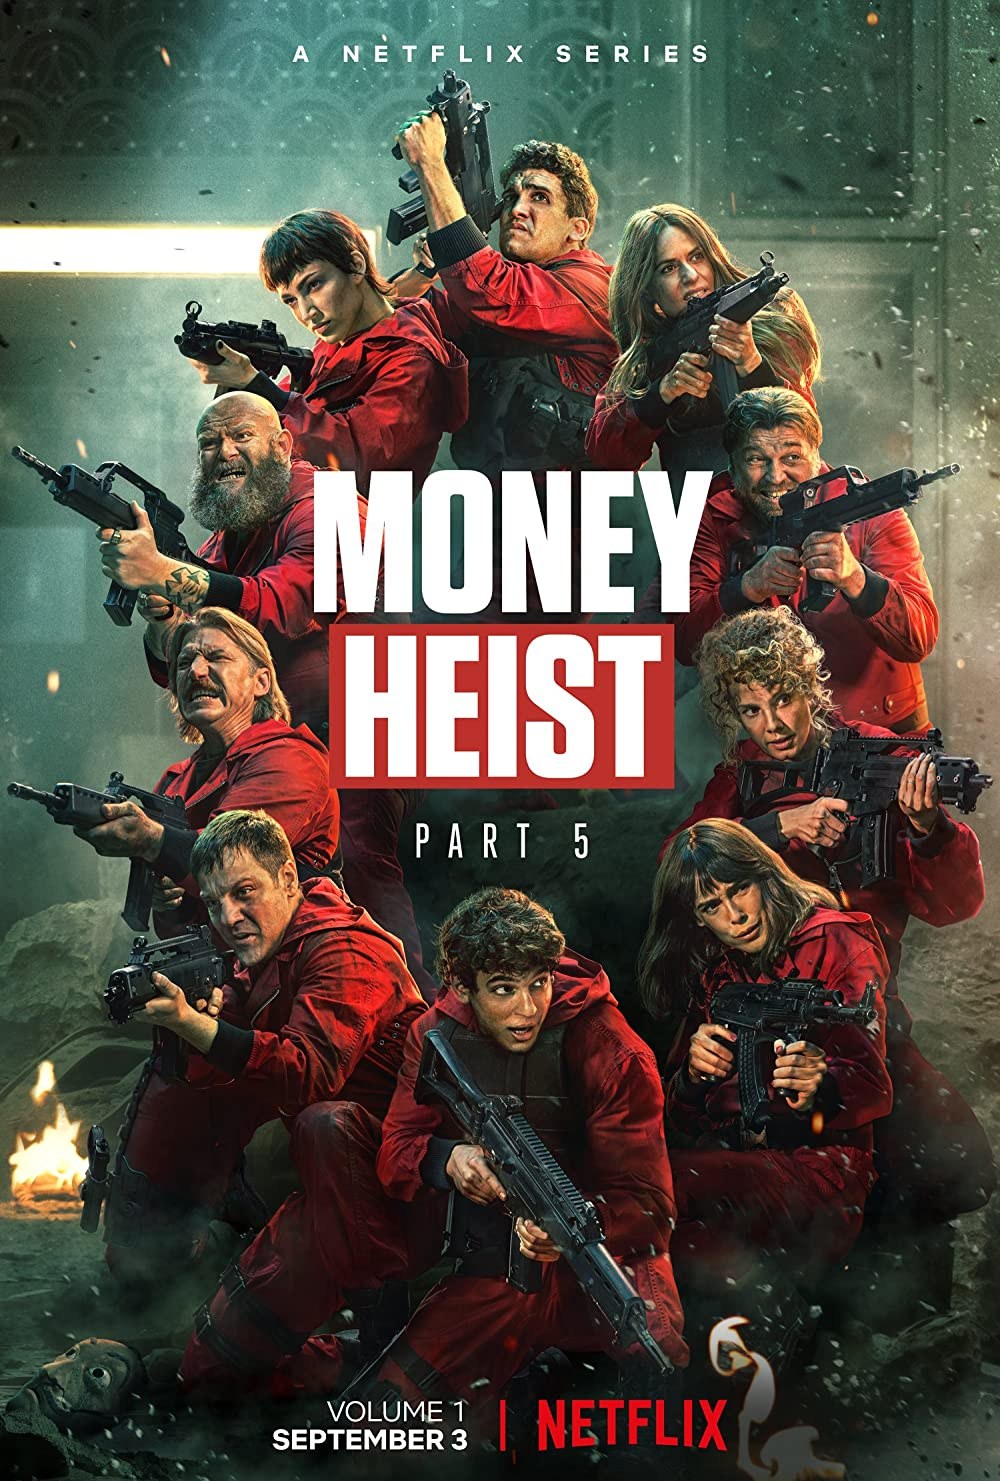

In [ ]:
from IPython.display import Image, display

# let's check the poster images for each movie
for path in paths:
  display(Image(path, width=100))

### Text Pre-processing (Movie Overviews)

In [ ]:
# prepare text cleaning and tokenizer
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tmdb-multimodal/dataset_mod_all.csv")
dataset['overview']

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
41505    It's the year 3000 AD. The world's most danger...
41506    Yet another version of the classic epic, with ...
41507          Rising and falling between a man and woman.
41508    An artist struggles to finish his work while a...
41509    When one of her hits goes wrong, a professiona...
Name: overview, Length: 41510, dtype: object

In [ ]:
# prepare the stopword list and lemmatizer
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# function to preprocess the movie overview texts
def clean_text(text):
  text = text.translate(str.maketrans('', '', punctuation)) # remove punctuations
  text = text.lower().strip() # lowercase
  text = ' '.join([i if i not in stop and i.isalpha() else '' for i in text.lower().split()]) # remove stopwords
  text = ' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(text)]) # lemmatization
  text = re.sub(r"\s{2,}", " ", text) # remove whitespace(s)
  return text

In [ ]:
# clean text from the dataset
dataset['overview'] = dataset['overview'].astype(str)
dataset['overview'] = dataset['overview'].apply(lambda text: clean_text(text))

# set parameters: max no. of word in the tokenizer & max sequence length
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = dataset['overview'].map(len).max()
print("Max. Sequence Length: ", MAX_SEQUENCE_LENGTH)

Max. Sequence Length:  868


In [ ]:
#clean the new movie overview texts
overviews = [clean_text(overview) for overview in raw_overviews]
overviews

['plot attack titan center civilization inside three wall last location human still live one hundred year ago humanity driven brink extinction emergence humanoid giant called titan attack eat human sight last remnant humanity retreated behind three concentric wall enjoyed nearly century peace combat titan country military employ vertical maneuvering equipment set waistmounted grappling hook gaspowered propulsion enabling immense mobility three dimension',
 'coming age romantic comedy revolves around choi ung choi wooshik kook yeonsoo kim dami exlovers broke promise never meet luck would documentary filmed ten year ago high school went viral forced face camera together producer friend seems feeling kook yeonsoo series depicts complicated feeling growth',
 'thousand year ago xu wenwu find ten ring ten mystical weapon grant user immortality great power wenwu amasses army warrior called ten ring conquers many kingdom topples government throughout history present day shangchi work valet bes

In [ ]:
# prepare the Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(dataset['overview'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 75944 unique tokens.


In [ ]:
# using the Tokenizer above, convert the listo f Movie Overview texts to an array of tokens, 
# and then pad with zero until max_length
input_texts = tokenizer.texts_to_sequences(overviews)
input_texts = pad_sequences(input_texts, maxlen=MAX_SEQUENCE_LENGTH)
input_texts

array([[    0,     0,     0, ..., 16382,    49,  4110],
       [    0,     0,     0, ...,   795,   535,  4715],
       [    0,     0,     0, ...,   213,  5144, 14001],
       [    0,     0,     0, ...,  1029,    71,   116]], dtype=int32)

In [ ]:
input_texts.shape

(4, 868)

### Image Pre-processing (Movie Posters)

In [ ]:
import cv2

# function to resize poster images and then normalize the data to a value between 0~1
def resize_img(path):
  try:
    img = cv2.imread(path)
    img = cv2.resize(img, (75, 115))
    img = img.astype(np.float32)/255
    return img
  except Exception as e:
    print(str(e))
    return None

In [ ]:
# convert the images to numpy arrays
imgs = [resize_img(path) for path in paths]
input_images = np.array(imgs)
print(input_images.shape)

(4, 115, 75, 3)


### Predict Genres

Now that the texts (`input_texts`) and images (`input_images`) are ready, let's call the model to predict their labels.

In [ ]:
out = model.predict([input_images, input_texts])
out

array([[0.30345643, 0.1650097 , 0.07079184, 0.22613758, 0.09135967,
        0.04711619, 0.2712095 , 0.04397291, 0.13350424, 0.03077763,
        0.3449623 , 0.0259943 , 0.08798826, 0.04600716, 0.3006089 ,
        0.2772208 , 0.02594334, 0.02745777],
       [0.01095355, 0.00669292, 0.01364464, 0.27987373, 0.01986751,
        0.6245298 , 0.2784414 , 0.01228574, 0.01211357, 0.03657758,
        0.01224628, 0.1816597 , 0.01046297, 0.0547125 , 0.01071954,
        0.01384506, 0.01260281, 0.00236994],
       [0.60677314, 0.46453673, 0.16471925, 0.14402384, 0.03431734,
        0.00955427, 0.16717324, 0.09169376, 0.29994282, 0.03596497,
        0.2693136 , 0.0109992 , 0.05756414, 0.03790411, 0.640185  ,
        0.2663751 , 0.04239696, 0.02165315],
       [0.61293656, 0.12362495, 0.00240475, 0.13672844, 0.44435507,
        0.00297657, 0.2348254 , 0.00262058, 0.01343101, 0.00973403,
        0.18563002, 0.00149342, 0.14312676, 0.01593697, 0.08136973,
        0.59856176, 0.00703216, 0.04419908]], dty

The above output shows an 2-d array:
- the first dimension has 4 elements which corresponds to the number of input (4 movie data)
- the second dimension has 18 elements which corresponds to the number of genres (18 genres)

Inside the array are the probabilities of a movie belonging to a certain genre, in the same order as the `genres` variable which is: `['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']`.

There are various way to use this `out` data to classify the movie data. One of the most common ways is to set a `threshold=0.5`. So any genre with a probability/confidence value above 0.5 will be considered the movie's genre. 

In this notebook, however, we take three genres with the biggest probability/confidence level, and then select the movie genres based on that. This below function does just that.

In [ ]:
import operator

def get_labels(pred):
  labels=[]
  
  indexed = list(enumerate(pred))
  top_3 = sorted(indexed, key=operator.itemgetter(1))[-3:]
  label_idxs = list(reversed([i for i, v in top_3]))
  
  for idx in label_idxs:
    labels.append(genres[idx])
  return labels

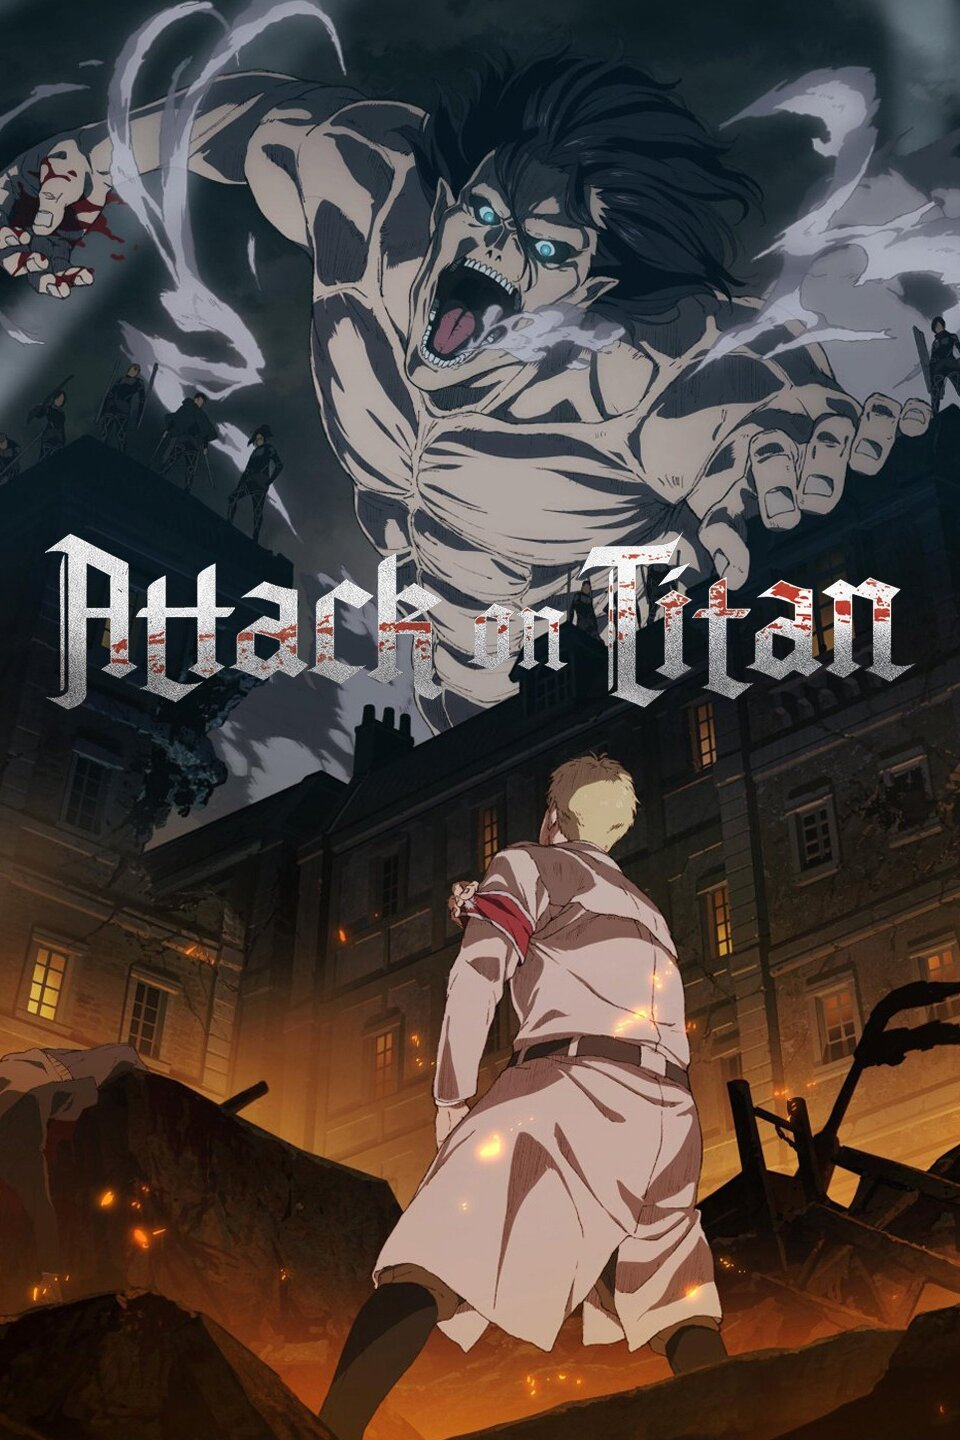

Synopsis:  The plot of Attack on Titan centers on a civilization inside three walls, the last location where humans still live. Over one hundred years ago, humanity was driven to the brink of extinction after the emergence of humanoid giants called Titans, who attack and eat humans on sight. The last remnants of humanity retreated behind three concentric walls and enjoyed nearly a century of peace. To combat Titans, the country's military employs Vertical Maneuvering Equipment, a set of waist-mounted grappling hooks and gas-powered propulsion enabling immense mobility in three dimensions.
Attack on Titan:  ['Horror', 'Action', 'Science Fiction']


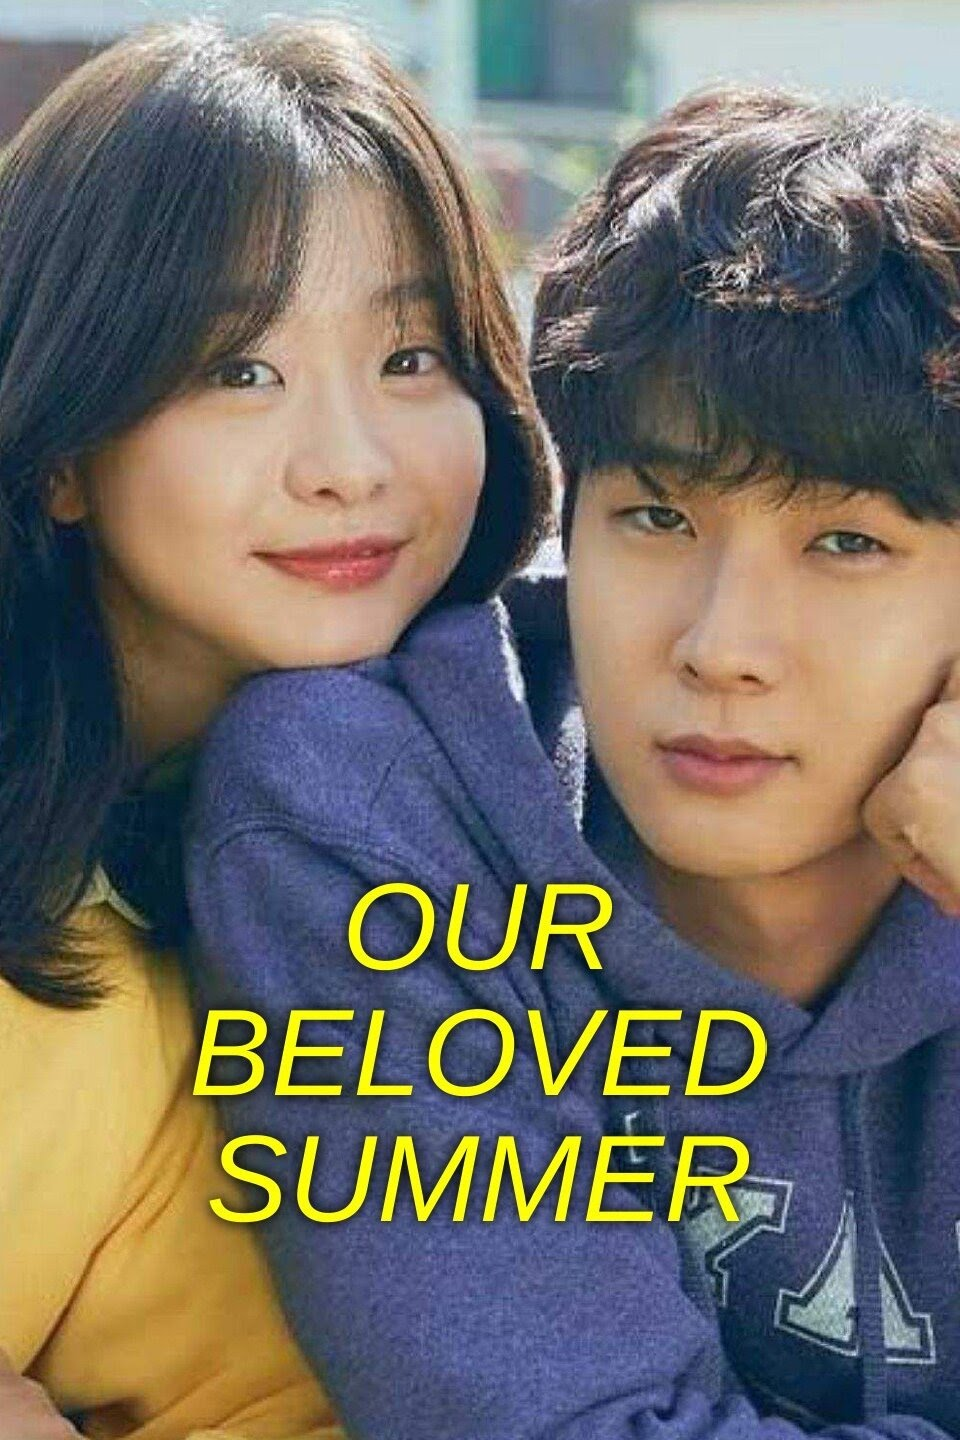

Synopsis:  A coming of age romantic comedy that revolves around Choi Ung (Choi Woo-shik) and Kook Yeon-Soo (Kim Da-mi), ex-lovers who broke up with a promise to never meet again. As luck would have it, the documentary they filmed ten years ago in high school went viral and they are forced to face the cameras together again by their producer friend who seems to have feelings for Kook Yeon-Soo. The series depicts their complicated feelings and growth.
Our Beloved Summer:  ['Documentary', 'Comedy', 'Drama']


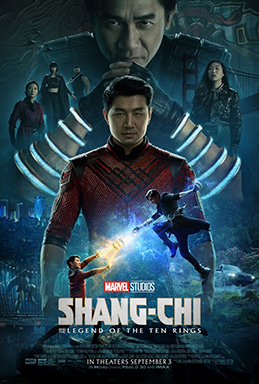

Synopsis:  Thousands of years ago, Xu Wenwu finds the Ten Rings, ten mystical weapons that grant their user immortality and great power. Wenwu amasses an army of warriors called the Ten Rings and conquers many kingdoms and topples governments throughout history. In the present day, Shang-Chi works as a valet with his best friend Katy. While on the bus on their way to work, Shang-Chi and Katy are attacked by the Ten Rings led by Razor Fist. Shang-Chi fights them off, but discovers that his pendant given to him by his mother has been taken. Fearing that the Ten Rings will attack Xialing for her pendant, Shang-Chi decides to track her down and reveals his past to Katy, who agrees to help him. They find her at an underground fight club in Macau, which she owns; Xialing expresses her resentment toward Shang-Chi and their father. The fight club is then attacked by the Ten Rings, with Wenwu unexpectedly arriving to capture Shang-Chi, Katy, and Xialing. Wenwu and the Ten Rings arrive to destro

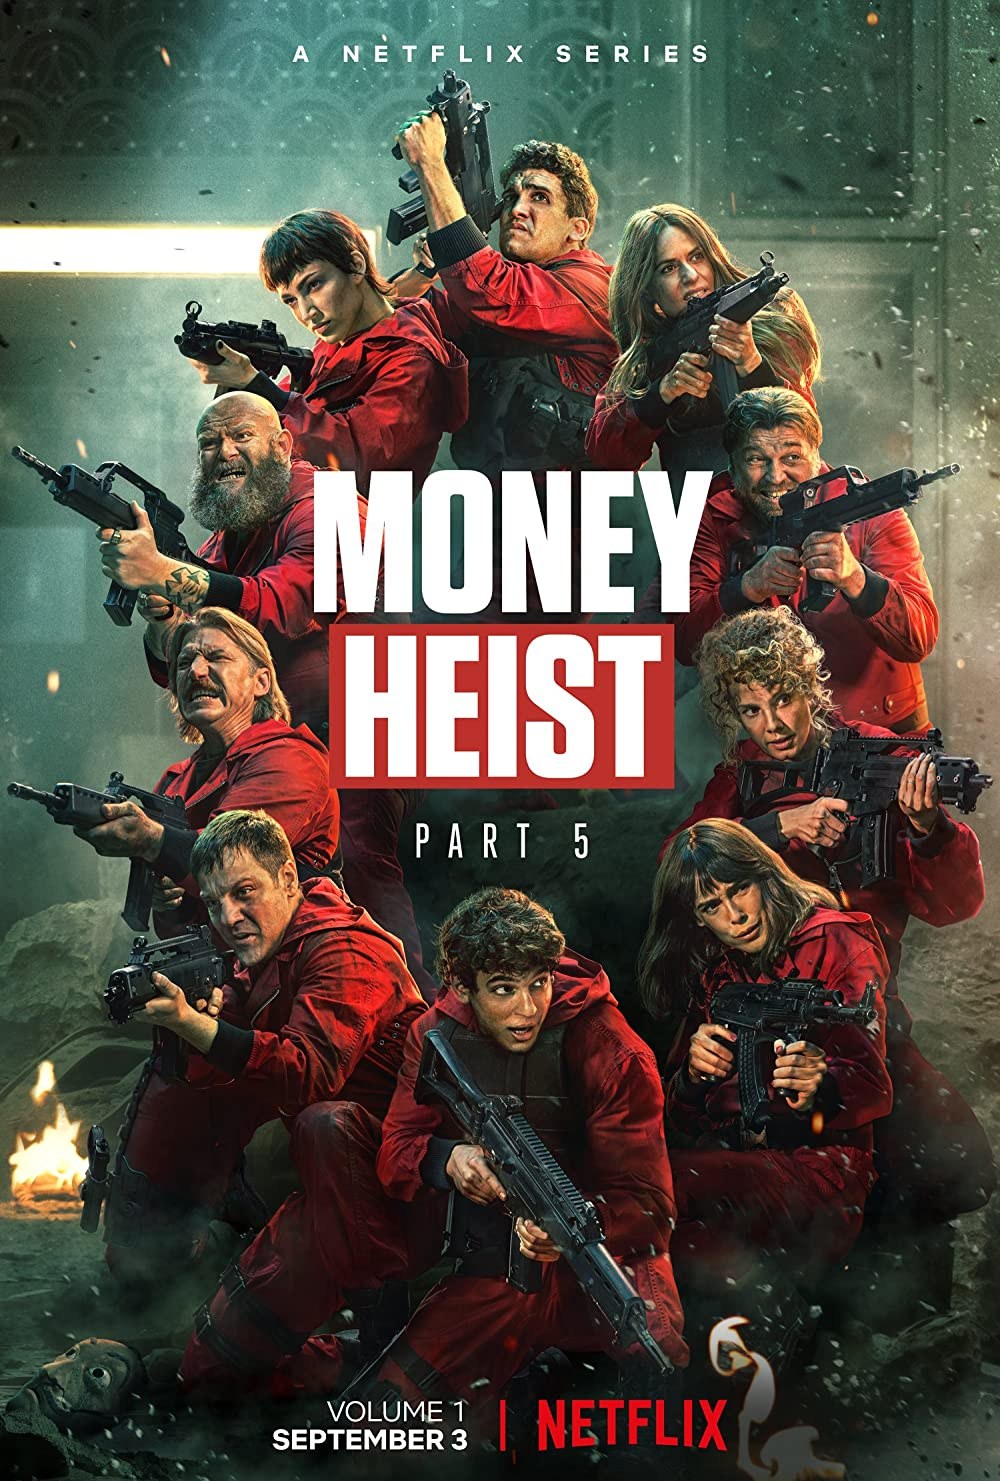

Synopsis:  Set in Madrid, a mysterious man known as the 'Professor' recruits a group of eight people, who choose city names as their aliases, to carry out an ambitious plan that involves entering the Royal Mint of Spain, and escaping with €984 million. After taking 67 people hostage inside the Mint, the team plans to remain inside for 11 days to print the money as they deal with elite police forces. In the events following the initial heist, the group's members are forced out of hiding and prepare for a second heist, this time on the Bank of Spain, as they again deal with hostages and police forces.
Money Heist / La Casa de Papel:  ['Action', 'Thriller', 'Crime']


In [ ]:
for idx, pred in enumerate(out):
  display(Image(paths[idx], width=100))
  print("Synopsis: ", raw_overviews[idx])
  print(titles[idx]+": ", get_labels(pred)) # get three genres with the biggest probability, out of 18 genres --> different from the Training IPYNB (we used the 0.5 threshold over there)

As can be seen above, **three genres** are selected for each movie.

So that concludes this notebook! Summary:
1. connect to Google Drive and import necessary packages
2. load trained model (trained w/ Keras) and prepare the available genres (18 genres)
3. prepare the movie data: overviews (text) and posters (image)
4. pre-process the text and image data
5. make predictions!